**Importando bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


#**Pré-Processamento**



In [2]:
# Leitura dos dados com colunas selecionadas
pedidos = pd.read_csv("olist_orders_dataset.csv", usecols=["order_id", "customer_id"])
itens_pedidos = pd.read_csv("olist_order_items_dataset.csv", usecols=["order_id", "product_id"])
produtos = pd.read_csv("olist_products_dataset.csv", usecols=["product_id", "product_category_name"])
avaliacoes_pedidos = pd.read_csv("olist_order_reviews_dataset.csv", usecols=["order_id", "review_score"])

# Renomeando colunas para português
pedidos.rename(columns={
    'order_id': 'id_pedido',
    'customer_id': 'id_cliente'
}, inplace=True)

itens_pedidos.rename(columns={
    'order_id': 'id_pedido',
    'product_id': 'id_produto'
}, inplace=True)

produtos.rename(columns={
    'product_id': 'id_produto',
    'product_category_name': 'categoria_produto'
}, inplace=True)

avaliacoes_pedidos.rename(columns={
    'order_id': 'id_pedido',
    'review_score': 'nota_avaliacao'
}, inplace=True)

In [3]:
# Mesclagem dos dados para formar a base do sistema de recomendação
dados_unificados = pd.merge(produtos, itens_pedidos, on='id_produto', how='inner')
dados_unificados = pd.merge(dados_unificados, pedidos, on='id_pedido', how='inner')
dados_unificados = pd.merge(dados_unificados, avaliacoes_pedidos, on='id_pedido', how='inner')

# Seleção das colunas relevantes para o sistema de recomendação
dados_sistema_recomendacao = dados_unificados[['id_cliente', 'id_produto', 'categoria_produto', 'nota_avaliacao']]


In [4]:
dados_sistema_recomendacao.duplicated().sum()

np.int64(10517)

In [5]:
# Remoção de duplicatas (cliente-produto) para evitar repetições nas recomendações
dados_sistema_recomendacao_limpo = dados_sistema_recomendacao.drop_duplicates(subset=['id_cliente', 'id_produto'])

# Verificação de duplicatas restantes
dados_sistema_recomendacao_limpo.duplicated().sum()


np.int64(0)

In [6]:
codificador_cliente = LabelEncoder()
codificador_produto = LabelEncoder()

# Aplicação do LabelEncoder às colunas de cliente e produto
dados_sistema_recomendacao_limpo.loc[:, 'id_cliente'] = codificador_cliente.fit_transform(dados_sistema_recomendacao_limpo['id_cliente'])
dados_sistema_recomendacao_limpo.loc[:, 'id_produto'] = codificador_produto.fit_transform(dados_sistema_recomendacao_limpo['id_produto'])


In [7]:
dados_sistema_recomendacao_limpo.isnull().sum()

,0
id_cliente,0
id_produto,0
categoria_produto,1448
nota_avaliacao,0


<Axes: xlabel='nota_avaliacao'>

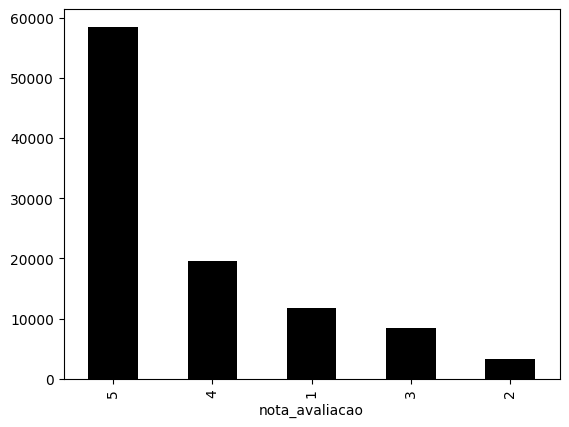

In [8]:
dados_sistema_recomendacao_limpo['nota_avaliacao'].value_counts().plot(kind='bar',color='Black')

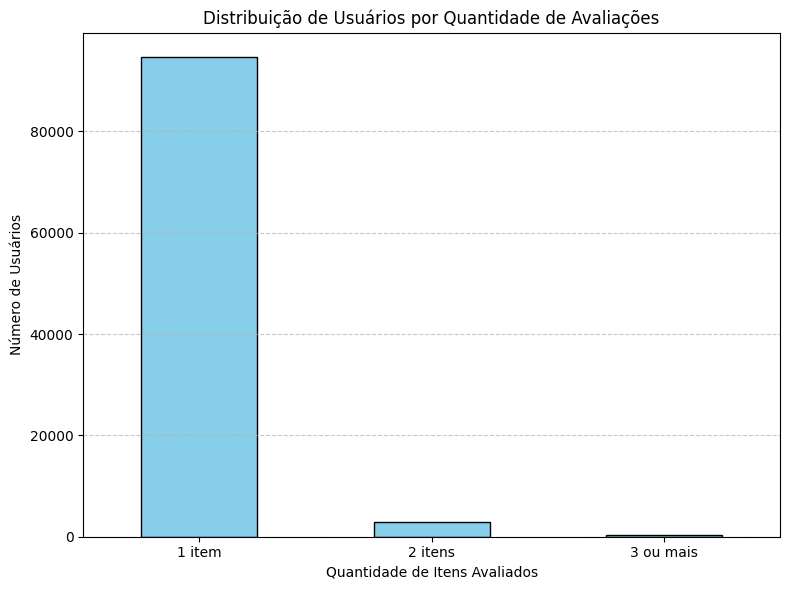

In [9]:
# 1. Contar quantos produtos cada usuário avaliou
avaliacoes_por_usuario = dados_sistema_recomendacao_limpo.groupby('id_cliente')['id_produto'].count()

# 2. Categorizar os usuários
def categoriza(qtd):
    if qtd == 1:
        return '1 item'
    elif qtd == 2:
        return '2 itens'
    else:
        return '3 ou mais'

categorias = avaliacoes_por_usuario.map(categoriza)

# 3. Contar usuários em cada categoria
distribuicao = categorias.value_counts().reindex(['1 item', '2 itens', '3 ou mais'], fill_value=0)

# 4. Plotar o gráfico
plt.figure(figsize=(8, 6))
distribuicao.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição de Usuários por Quantidade de Avaliações')
plt.xlabel('Quantidade de Itens Avaliados')
plt.ylabel('Número de Usuários')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Filtragem dos clientes que avaliaram pelo menos 2 produtos
dados_sistema_recomendacao_finalizado = dados_sistema_recomendacao_limpo.groupby('id_cliente').filter(lambda x: len(x) >= 2)

In [11]:
def filtrar_por_cliente(id_cliente, dataframe):
    return dataframe[dataframe['id_cliente'] == id_cliente]

**Dividindo o DataFrame em treino (70%) e teste (30%)**



In [12]:
# Separação dos dados em treino e teste
dados_treino, dados_teste = train_test_split(dados_sistema_recomendacao_finalizado, test_size=0.3, random_state=42)

print("Conjunto de treino:")
print(dados_treino)

print("\nConjunto de teste:")
print(dados_teste)

Conjunto de treino:
       id_cliente id_produto            categoria_produto  nota_avaliacao
106669      67163      17682              cama_mesa_banho               2
72618       37910       8741                esporte_lazer               3
105227      79243      18945              cama_mesa_banho               4
59675       53523      12091              cama_mesa_banho               5
22770       67451      32679           relogios_presentes               4
...           ...        ...                          ...             ...
61745       43386      16853                 beleza_saude               5
83174       74016       7117              cama_mesa_banho               4
83744        4007      10693           ferramentas_jardim               1
86423       84741      20606  fashion_bolsas_e_acessorios               5
15296       35002      15145           ferramentas_jardim               5

[4835 rows x 4 columns]

Conjunto de teste:
      id_cliente id_produto            categori

# **Filtragem de Conteúdo Baseado em Item**

In [13]:
# Criação da matriz usuário-item com pontuações médias de avaliação
matriz_cliente_produto = dados_treino.pivot_table(
    index='id_cliente',
    columns='id_produto',
    values='nota_avaliacao'
).fillna(0).astype(int)

In [14]:
matriz_cliente_produto

id_produto,9,31,38,40,50,58,73,77,90,112,...,32694,32696,32715,32722,32742,32748,32761,32766,32775,32781
id_cliente,,,,,,,,,,,,,,,,,,,,,
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
def calcular_similaridade_cosseno_ajustada(matriz_cliente_produto, id_produto_1, id_produto_2):
    numerador = 0
    somatorio_ajuste_1 = 0
    somatorio_ajuste_2 = 0

    for index, row in matriz_cliente_produto.iterrows():
        nota_1 = row.get(id_produto_1, 0)
        nota_2 = row.get(id_produto_2, 0)

        # Considera apenas se o usuário avaliou os dois produtos
        if nota_1 > 0 and nota_2 > 0:
            # Média das avaliações feitas pelo usuário (valores > 0)
            avaliacoes_usuario = row[row > 0]
            media_usuario = avaliacoes_usuario.mean()

            diff_1 = nota_1 - media_usuario
            diff_2 = nota_2 - media_usuario

            numerador += diff_1 * diff_2
            somatorio_ajuste_1 += diff_1 ** 2
            somatorio_ajuste_2 += diff_2 ** 2

    denominador = np.sqrt(somatorio_ajuste_1) * np.sqrt(somatorio_ajuste_2)

    # Evita divisão por zero
    if denominador == 0:
        return 0

    return numerador / denominador

In [16]:
def encontrar_itens_similares_ao_item_alvo(matriz_cliente_produto, usuario_alvo, itens_avaliados_pelo_usuario_alvo):

    id_cliente_alvo = usuario_alvo['id_cliente']
    id_produto_alvo = usuario_alvo['id_produto']

    # Verifica se o subconjunto não está vazio
    if itens_avaliados_pelo_usuario_alvo.empty:
        #print("Subconjunto está vazio. Retornando DataFrame vazio.")
        return pd.DataFrame(columns=['id_produto', 'similaridade'])

    # Lista para armazenar os resultados
    resultados = []

    # Percorre o subconjunto
    for _, linha in itens_avaliados_pelo_usuario_alvo.iterrows():
        id_produto_linha = linha['id_produto']
        # Calcula a similaridade usando o método calcular_similaridade_cosseno_ajustada
        try:
            similaridade = calcular_similaridade_cosseno_ajustada(matriz_cliente_produto, id_produto_alvo, id_produto_linha)
        except Exception as e:
            #print(f"Erro ao calcular similaridade cosseno ajustado para produto de id {id_produto_linha}: {e}")
            similaridade = None

        # Armazena o resultado em um dicionário apenas se similaridade for válida
        if similaridade is not None:
            resultados.append({
                'id_produto': id_produto_linha,
                'similaridade': similaridade
            })

    # Cria um DataFrame com os resultados
    resultado_df = pd.DataFrame(resultados)

    # Ordena o DataFrame por similaridade em ordem decrescente
    if not resultado_df.empty:
        resultado_df = resultado_df.sort_values(by='similaridade', ascending=False)

    return resultado_df

In [17]:
def obter_itens_avaliados_pelo_usuario_alvo(usuario_teste, dados_teste):
    id_cliente = usuario_teste['id_cliente']
    id_produto = usuario_teste['id_produto']

    # Pega as outras avaliações do usuário no conjunto de treino, exceto a avaliação do produto alvo
    avaliacoes = dados_treino[
        (dados_treino['id_cliente'] == id_cliente) &
        (dados_treino['id_produto'] != id_produto)
    ]

    return avaliacoes

In [18]:
def realizar_previsao_filtragem_colaborativa(dados_treino, dados_teste, matriz_cliente_produto):
    id_cliente = dados_teste['id_cliente']
    id_produto = dados_teste['id_produto']

    avaliacoes_cliente = dados_treino[
        (dados_treino['id_cliente'] == id_cliente) & (dados_treino['nota_avaliacao'] != 0)
    ]['nota_avaliacao']

    media_cliente = avaliacoes_cliente.mean() if not avaliacoes_cliente.empty else 0
    numerador = 0
    denominador = 0
    k_utilizado = 0

    itens_avaliados_pelo_usuario_alvo = obter_itens_avaliados_pelo_usuario_alvo(dados_teste, dados_treino)
    lista_similares = encontrar_itens_similares_ao_item_alvo(
        matriz_cliente_produto,
        dados_teste,
        itens_avaliados_pelo_usuario_alvo
    )

    for _, linha in lista_similares.iterrows():
        id_produto_linha = linha['id_produto']
        similaridade_linha = linha['similaridade']

        nota_avaliacao_linha = dados_treino[
            (dados_treino['id_cliente'] == id_cliente) & (dados_treino['id_produto'] == id_produto_linha)
        ]['nota_avaliacao'].mean()

        if pd.isna(nota_avaliacao_linha):
            continue  # Ignora se o usuário não avaliou esse item

        numerador += similaridade_linha * (nota_avaliacao_linha - media_cliente)
        denominador += abs(similaridade_linha)
        k_utilizado += 1  # conta somente os itens realmente usados na previsão

    previsao = (numerador / denominador + media_cliente) if denominador != 0 else media_cliente
    return previsao, k_utilizado


In [19]:
def teste_de_previsao_filtragem_colaborativa_baseada_em_itens(df_teste, df_treino):
    matriz_cliente_produto = dados_treino.pivot_table(
      index='id_cliente',
      columns='id_produto',
      values='nota_avaliacao'
      ).fillna(0).astype(int)

    resultados_sucesso = []  # Lista para armazenar os registros bem-sucedidos

    for _, linha_teste in df_teste.iterrows():
        try:
            # Chama os métodos para processar a linha
            resultado, k_utilizado = realizar_previsao_filtragem_colaborativa(
                df_treino,
                linha_teste,
                matriz_cliente_produto
            )
            # Adiciona o resultado bem-sucedido à lista
            resultados_sucesso.append({
                'id_cliente': linha_teste['id_cliente'],
                'id_produto': linha_teste['id_produto'],
                'nota_avaliacao_real': linha_teste['nota_avaliacao'],  # Adiciona o campo nota_avaliacao
                'nota_avaliacao_prevista': round(resultado),
                'k_utilizado': k_utilizado
            })
        except Exception as e:
            print(f"Erro ao processar a linha {linha_teste.to_dict()}: {e}")

    # Converte os resultados bem-sucedidos para um DataFrame
    df_resultado = pd.DataFrame(resultados_sucesso)

    # Calcula as quantidades de sucessos e erros
    registros_sucesso = len(resultados_sucesso)
    registros_erro = len(df_teste) - registros_sucesso

    # Exibe as informações de processamento
    print(f"Registros processados com sucesso: {registros_sucesso}")
    print(f"Registros com erro: {registros_erro}")

    return df_resultado

In [22]:
resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens = teste_de_previsao_filtragem_colaborativa_baseada_em_itens(dados_teste, dados_treino)
resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens

Registros processados com sucesso: 2073
Registros com erro: 0


,id_cliente,id_produto,nota_avaliacao_real,nota_avaliacao_prevista,k_utilizado
0,51617,15513,4,4,1
1,18765,6133,1,1,1
2,16230,6985,5,5,1
3,50553,1315,5,5,1
4,88272,10532,2,2,2
...,...,...,...,...,...
2068,26075,5316,5,5,1
2069,60213,7865,5,5,1
2070,1805,5277,3,3,2
2071,33387,19176,1,1,1


# **Filtragem Baseada em Conteúdo**

In [23]:
def criar_perfis_itens(dados_treino):
    descricao = (
        dados_treino['categoria_produto'].fillna('')
    )
    descricao = (
        descricao
        .str.lower()
        .str.replace('_', ' ', regex=False)
        .apply(lambda x: re.sub(r'\s+', ' ', x))
        .str.strip()
    )

    vectorizer = TfidfVectorizer(stop_words=['portuguese'])
    matriz_tfidf = vectorizer.fit_transform(descricao)

    return matriz_tfidf, vectorizer, vectorizer.get_feature_names_out()

In [24]:
def identificar_classificados_por_usuario_teste(usuario_teste, dados_treino):
    id_usuario_teste = usuario_teste['id_cliente']
    classificados_por_usuario_teste = dados_treino[dados_treino['id_cliente'] == id_usuario_teste]
    return classificados_por_usuario_teste

In [25]:
def criar_perfil_usuario(df_usuario, vectorizer):
    #Cria o perfil de usuário com base nos produtos que ele avaliou,utilizando o vectorizer treinado com os itens do treino.

    # Combina e pré-processa os textos
    descricao = (
        df_usuario['categoria_produto'].fillna('')
    )
    descricao = (
        descricao
        .str.lower()
        .str.replace('_', ' ', regex=False)
        .apply(lambda x: re.sub(r'\s+', ' ', x))
        .str.strip()
    )

    # Aplica o vectorizer treinado para transformar os textos dos produtos avaliados
    matriz_tfidf = vectorizer.transform(descricao)

    # Calcula o vetor médio (perfil do usuário)
    perfil_usuario = matriz_tfidf.mean(axis=0)

    # Retorna como Series com nomes dos termos
    return pd.Series(perfil_usuario.A1.flatten(), index=vectorizer.get_feature_names_out())

In [26]:
def criar_perfil_item(produto, vectorizer): #Cria o vetor TF-IDF de um único produto usando um vectorizer já treinado.

    # Trata valores nulos e processa o texto
    cat_pt = str(produto.get('categoria_produto', '') or '')

    descricao = f"{cat_pt}"
    descricao = re.sub(r'\s+', ' ', descricao.replace('_', ' ').lower()).strip()

    # Gera o vetor TF-IDF
    vetor = vectorizer.transform([descricao])

    # Converte para vetor plano
    return pd.Series(vetor.toarray().flatten(), index=vectorizer.get_feature_names_out())



In [28]:
usuario_teste = dados_teste.iloc[2]  # Linha de df_teste
item_teste = dados_teste.iloc[2]  # Linha de df_teste
itens_classificados = identificar_classificados_por_usuario_teste(usuario_teste, dados_treino)
_, vectorizer, _ = criar_perfis_itens(dados_treino[['categoria_produto']])
perfil_usuario = criar_perfil_usuario(usuario_teste.to_frame().T, vectorizer)
perfil_item = criar_perfil_item(item_teste, vectorizer)

In [29]:
perfil_usuario.to_frame().T

,acessorios,agro,alimentos,area,artes,artesanato,artigos,audio,automotivo,banho,...,seguranca,servico,shop,sinalizacao,stuff,tablets,tecnicos,telefonia,underwear,utilidades
0,0.479957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
perfil_item.to_frame().T

,acessorios,agro,alimentos,area,artes,artesanato,artigos,audio,automotivo,banho,...,seguranca,servico,shop,sinalizacao,stuff,tablets,tecnicos,telefonia,underwear,utilidades
0,0.479957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
def similaridade_usuario_item(perfil_usuario, perfil_item):
    #Calcula a similaridade do cosseno entre o perfil de um usuário e o perfil de um item.

    vetor_u = perfil_usuario.values.reshape(1, -1)
    vetor_i = perfil_item.values.reshape(1, -1)
    return float(cosine_similarity(vetor_u, vetor_i)[0][0])


In [32]:
def similaridade_entre_itens(perfil_item1, perfil_item2):

    vetor1 = perfil_item1.values.reshape(1, -1)
    vetor2 = perfil_item2.values.reshape(1, -1)
    return float(cosine_similarity(vetor1, vetor2)[0][0])


In [36]:
def realizar_previsao_filtragem_baseada_conteudo(dados_treino, usuario_teste):
    #Realiza a previsão da nota que um usuário daria a um item, com base na similaridade entre o perfil do item e o perfil do usuário.

    id_usuario = usuario_teste['id_cliente']
    id_item_alvo = usuario_teste['id_produto']

    # 1. Criar os perfis de itens do treino e o vectorizer
    _, vectorizer, _ = criar_perfis_itens(dados_treino[['categoria_produto']])

    # 2. Criar o perfil do item a ser avaliado
    perfil_item_alvo = criar_perfil_item(usuario_teste, vectorizer)

    # 3. Obter os itens avaliados pelo usuário no treino
    itens_usuario = identificar_classificados_por_usuario_teste(usuario_teste, dados_treino)

    if itens_usuario.empty:
        return 0  # Sem histórico, não é possível prever

    # 4. Criar o perfil do usuário (com o mesmo vectorizer)
    perfil_usuario = criar_perfil_usuario(itens_usuario, vectorizer)

    # 5. Calcular a similaridade entre o item alvo e o perfil do usuário
    similaridade = similaridade_usuario_item(perfil_usuario, perfil_item_alvo)

    # 6. Obter os 3 itens mais similares (ao item alvo) dentre os que o usuário avaliou
    similares = []

    for _, item in itens_usuario.iterrows():
        perfil_item_treinado = criar_perfil_item(item, vectorizer)
        sim = similaridade_entre_itens(perfil_item_alvo, perfil_item_treinado)

        if sim > 0.3:
            similares.append({
                'id_produto': item['id_produto'],
                'similaridade': sim,
                'nota_avaliacao': item['nota_avaliacao']
            })

    if not similares:
        return 0  # Nenhum item com similaridade suficiente

    df_similares = pd.DataFrame(similares).sort_values(by='similaridade', ascending=False).head(3)

    numerador = 0
    denominador = 0

    # 7. Previsão pela média ponderada pela similaridade
    for _, item in df_similares.iterrows():
      numerador += similaridade * item['nota_avaliacao']
      denominador += similaridade

    if denominador == 0:
        return 0

    return numerador / denominador

In [37]:
def teste_de_previsao_filtragem_baseada_conteudo(df_treino, df_teste):
  resultados_sucesso = []  # Lista para armazenar os registros bem-sucedidos

  for _, linha_teste in df_teste.iterrows():
      try:
          # Chama os métodos para processar a linha
          resultado = realizar_previsao_filtragem_baseada_conteudo(
              df_treino,
              linha_teste
          )
          # Adiciona o resultado bem-sucedido à lista
          resultados_sucesso.append({
              'id_cliente': linha_teste['id_cliente'],
              'id_produto': linha_teste['id_produto'],
              'nota_avaliacao_real': linha_teste['nota_avaliacao'],  # Adiciona o campo nota_avaliacao
              'nota_avaliacao_prevista': round(resultado)
          })
      except Exception as e:
          print(f"Erro ao processar a linha {linha_teste.to_dict()}: {e}")

  # Converte os resultados bem-sucedidos para um DataFrame
  df_resultado = pd.DataFrame(resultados_sucesso)

  # Calcula as quantidades de sucessos e erros
  registros_sucesso = len(resultados_sucesso)
  registros_erro = len(df_teste) - registros_sucesso

  # Exibe as informações de processamento
  print(f"Registros processados com sucesso: {registros_sucesso}")
  print(f"Registros com erro: {registros_erro}")

  return df_resultado

In [38]:
resultados_das_previsoes_da_filtragem_baseada_conteudo = teste_de_previsao_filtragem_baseada_conteudo(dados_treino, dados_teste)

Registros processados com sucesso: 2073
Registros com erro: 0


In [ ]:
resultados_das_previsoes_da_filtragem_baseada_conteudo

,id_cliente,id_produto,nota_avaliacao_real,nota_avaliacao_prevista
0,51617,15513,4,4
1,18765,6133,1,1
2,16230,6985,5,5
3,50553,1315,5,5
4,88272,10532,2,2
...,...,...,...,...
2068,26075,5316,5,5
2069,60213,7865,5,0
2070,1805,5277,3,3
2071,33387,19176,1,1


# **Filtragem Híbrida**

In [39]:
def realizar_previsao_filtragem_hibrida(linha_fc, linha_cb):
    id_cliente = linha_fc['id_cliente']
    id_produto = linha_fc['id_produto']
    nota_avaliacao = linha_fc['nota_avaliacao_real']

    resultado_previsao_fc = linha_fc['nota_avaliacao_prevista']
    resultado_previsao_cb = linha_cb['nota_avaliacao_prevista']

    # t_u: número de similares realmente usados (vizinhos com nota)
    t_u = linha_fc['k_utilizado']

    # k: máximo de itens similares considerados na vizinhança
    k_total = 3

    # Cálculo do fator de confiança
    alfa = (t_u / k_total) * 0.9 if k_total != 0 else 0
    alfa = min(alfa, 1)  # limitar alfa a no máximo 1

    resultado_hibrido = round(alfa * resultado_previsao_fc + (1 - alfa) * resultado_previsao_cb)

    return pd.DataFrame([{
        'id_cliente': id_cliente,
        'id_produto': id_produto,
        'nota_avaliacao_real': nota_avaliacao,
        'nota_avaliacao_prevista': resultado_hibrido
    }])

In [40]:
def teste_filtragem_hibrida(resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens,
                            resultados_das_previsoes_da_filtragem_baseada_conteudo):
    linhas_hibridas = []

    for i in range(len(resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens)):
        linha_fc = resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens.iloc[i]
        linha_fcconteudo = resultados_das_previsoes_da_filtragem_baseada_conteudo.iloc[i]

        linha_hibrida = realizar_previsao_filtragem_hibrida(linha_fc, linha_fcconteudo)
        linhas_hibridas.append(linha_hibrida)

    resultado_hibrido_df = pd.concat(linhas_hibridas, ignore_index=True)
    return resultado_hibrido_df

In [41]:
resultado_fcbi = resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens
resultado_fbc = resultados_das_previsoes_da_filtragem_baseada_conteudo
resultados_das_previsoes_da_filtragem_hibrida = teste_filtragem_hibrida(resultado_fcbi, resultado_fbc)

In [42]:
resultados_das_previsoes_da_filtragem_hibrida

,id_cliente,id_produto,nota_avaliacao_real,nota_avaliacao_prevista
0,51617,15513,4,4
1,18765,6133,1,1
2,16230,6985,5,5
3,50553,1315,5,5
4,88272,10532,2,2
...,...,...,...,...
2068,26075,5316,5,5
2069,60213,7865,5,2
2070,1805,5277,3,3
2071,33387,19176,1,1


#**Métricas RSME e MAE**

In [43]:
def calcular_erros(df_resultado):

    #Calcula as métricas RMSE e MAE para o DataFrame resultante do método anterior,
    #considerando apenas os registros com `resultado_previsao` diferente de 0.

    #Parâmetros:
        #df_resultado (pd.DataFrame): DataFrame com as colunas `review_score` e `resultado_previsao`.

    #Retorno:
        #pd.DataFrame: DataFrame com as métricas calculadas e contagens.

    # Filtrar os registros onde resultado_previsao é diferente de 0
    df_valido = df_resultado[df_resultado['nota_avaliacao_prevista'] != 0].copy()
    df_avaliado = df_resultado.copy()

    # Contar registros válidos e inválidos
    registros_validos = int(len(df_valido))  # Converter para inteiro
    registros_invalidos = int(len(df_resultado) - registros_validos)  # Converter para inteiro

    # Calcular as diferenças absolutas e quadradas usando .loc
    df_avaliado.loc[:, 'erro_absoluto'] = abs(df_avaliado['nota_avaliacao_real'] - df_avaliado['nota_avaliacao_prevista'])
    df_avaliado.loc[:, 'erro_quadrado'] = (df_avaliado['nota_avaliacao_real'] - df_avaliado['nota_avaliacao_prevista']) ** 2

    # Calcular MAE e RMSE
    mae = df_avaliado['erro_absoluto'].mean()
    rmse = np.sqrt(df_avaliado['erro_quadrado'].mean())

    # Criar o DataFrame de métricas
    df_metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'Classificações Válidas', 'Classificações Inválidas'],
        'Valor': [mae, rmse, registros_validos, registros_invalidos]
    })

    return df_metricas


In [44]:
erros_da_filtragem_colaborativa_baseada_em_itens = calcular_erros(resultados_das_previsoes_da_filtragem_colaborativa_baseada_em_itens)
erros_da_filtragem_baseada_em_conteudo = calcular_erros(resultados_das_previsoes_da_filtragem_baseada_conteudo)
erros_da_filtragem_hibrida = calcular_erros(resultados_das_previsoes_da_filtragem_hibrida)

In [45]:
erros_da_filtragem_colaborativa_baseada_em_itens

,Métrica,Valor
0,MAE,0.828268
1,RMSE,1.858346
2,Classificações Válidas,1549.000000
3,Classificações Inválidas,524.000000


In [46]:
erros_da_filtragem_baseada_em_conteudo

,Métrica,Valor
0,MAE,1.330921
1,RMSE,2.332162
2,Classificações Válidas,1198.000000
3,Classificações Inválidas,875.000000


In [47]:
erros_da_filtragem_hibrida

,Métrica,Valor
0,MAE,1.157260
1,RMSE,2.062576
2,Classificações Válidas,1436.000000
3,Classificações Inválidas,637.000000
